# Proyek Klasifikasi Gambar: [Guava Fruit Disease Dataset]
- **Nama:** [Andreas Adi Prasetyo]
- **Email:** [mc615d5y1588@student.devacademy.id]
- **ID Dicoding:** [MC615D5Y1588]
- **link dataset:** https://www.kaggle.com/datasets/asadullahgalib/guava-disease-dataset

## Import Semua Packages/Library yang Digunakan

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

## Data Preparation

### Data Loading

In [15]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adidobol","key":"0f52c6bd054be29c13d1c22fd46f2614"}'}

In [16]:
import os
import zipfile

# Pindahkan dan setup credential
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)

In [18]:
!kaggle datasets download -d asadullahgalib/guava-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/asadullahgalib/guava-disease-dataset
License(s): Attribution 4.0 International (CC BY 4.0)


In [19]:
with zipfile.ZipFile('guava-disease-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('guava-data')

In [20]:
import os
# Base folder path
base_dir = '/content/guava-data/GuavaDiseaseDataset/GuavaDiseaseDataset'

# Hitung jumlah gambar di masing-masing set
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(base_dir, split)
    total_images = sum([len(files) for r, d, files in os.walk(split_dir)])
    print(f"Jumlah gambar di {split}: {total_images}")

Jumlah gambar di train: 2647
Jumlah gambar di val: 755
Jumlah gambar di test: 382


Kelas yang tersedia: ['fruit_fly', 'healthy_guava', 'Anthracnose']


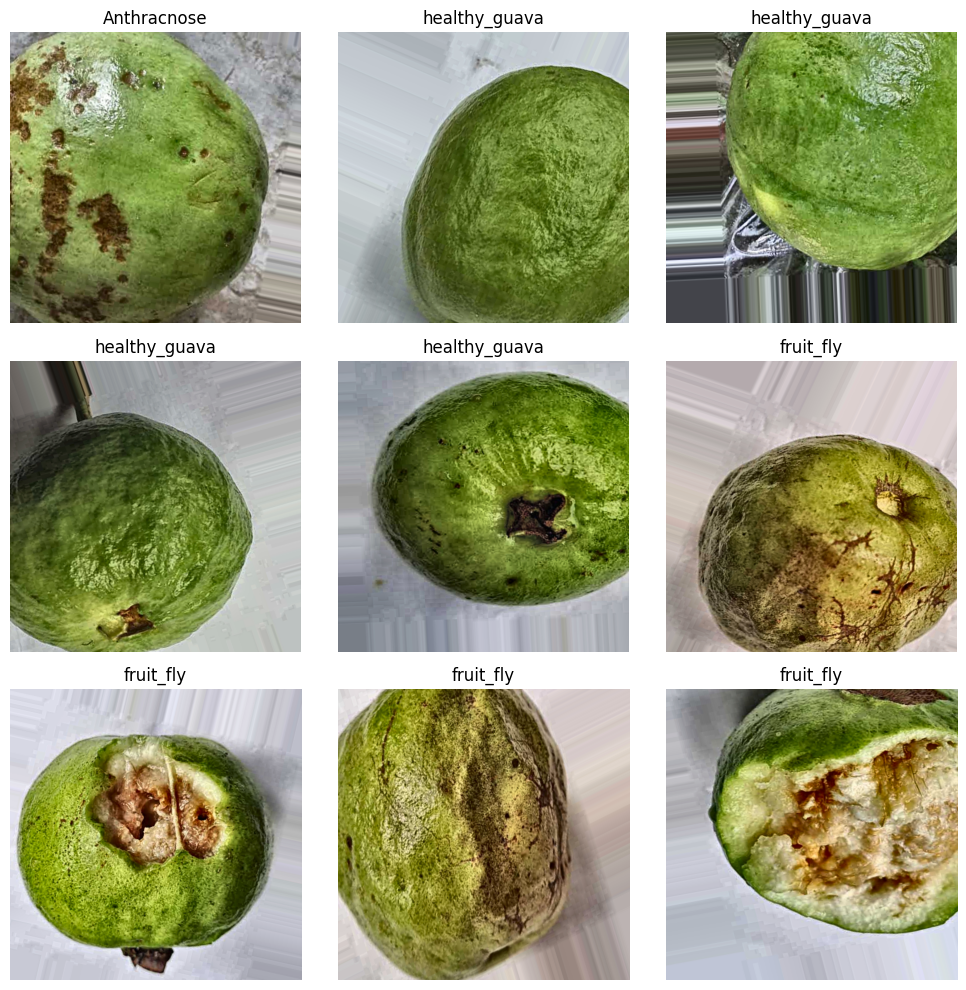

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

split = 'train'
split_dir = os.path.join(base_dir, split)

# Ambil daftar semua kelas
classes = os.listdir(split_dir)
print("Kelas yang tersedia:", classes)

# Ambil beberapa gambar random
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for img_ax in axes:
    chosen_class = random.choice(classes)
    class_dir = os.path.join(split_dir, chosen_class)
    img_file = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_file)

    img = mpimg.imread(img_path)
    img_ax.imshow(img)
    img_ax.set_title(chosen_class)
    img_ax.axis('off')

plt.tight_layout()
plt.show()

Kelas yang tersedia: ['fruit_fly', 'healthy_guava', 'Anthracnose']


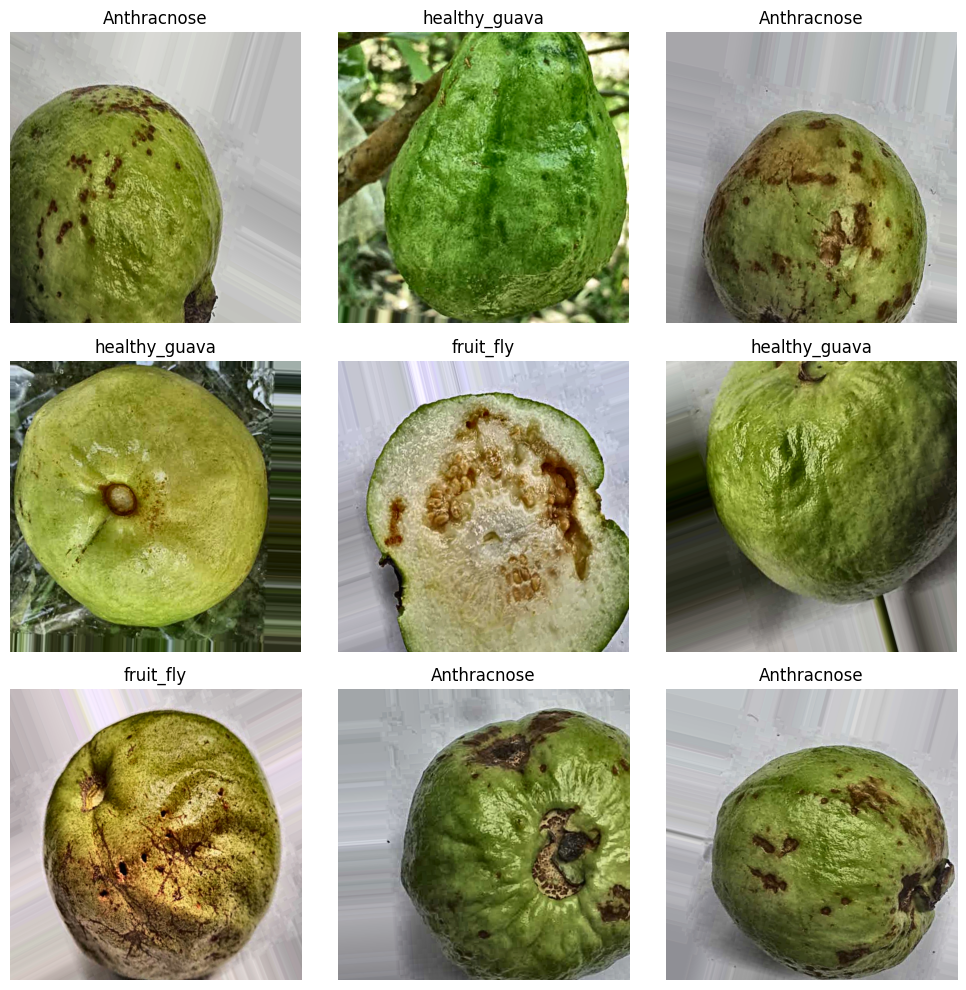

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

split = 'val'
split_dir = os.path.join(base_dir, split)

# Ambil daftar semua kelas
classes = os.listdir(split_dir)
print("Kelas yang tersedia:", classes)

# Ambil beberapa gambar random
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for img_ax in axes:
    chosen_class = random.choice(classes)
    class_dir = os.path.join(split_dir, chosen_class)
    img_file = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_file)

    img = mpimg.imread(img_path)
    img_ax.imshow(img)
    img_ax.set_title(chosen_class)
    img_ax.axis('off')

plt.tight_layout()
plt.show()


Kelas yang tersedia: ['fruit_fly', 'healthy_guava', 'Anthracnose']


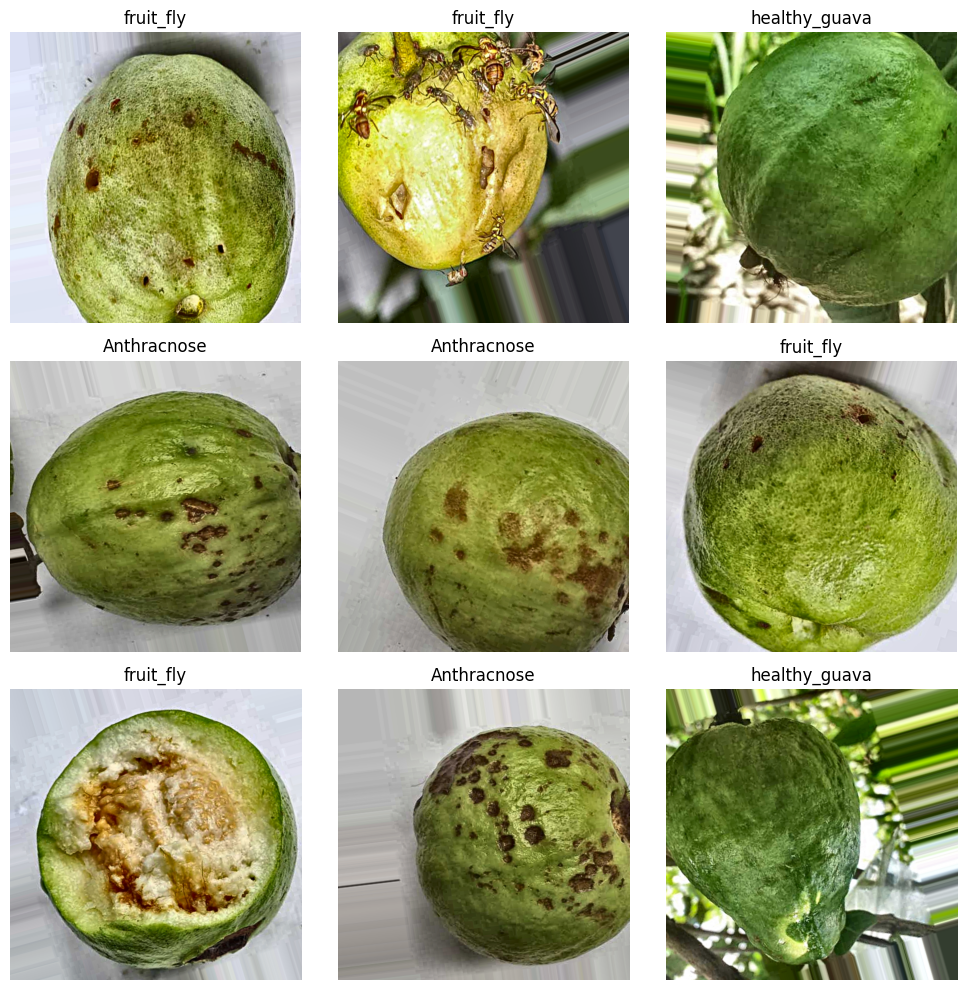

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

split = 'test'
split_dir = os.path.join(base_dir, split)

# Ambil daftar semua kelas
classes = os.listdir(split_dir)
print("Kelas yang tersedia:", classes)

# Ambil beberapa gambar random
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for img_ax in axes:
    chosen_class = random.choice(classes)
    class_dir = os.path.join(split_dir, chosen_class)
    img_file = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_file)

    img = mpimg.imread(img_path)
    img_ax.imshow(img)
    img_ax.set_title(chosen_class)
    img_ax.axis('off')

plt.tight_layout()
plt.show()


### Data Preprocessing

#### Split Dataset

In [24]:
# Set parameter
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

# Base path
base_dir = '/content/guava-data/GuavaDiseaseDataset/GuavaDiseaseDataset'

# ImageDataGenerator untuk TRAIN (dengan augmentasi)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Untuk VALIDASI dan TEST (tanpa augmentasi, hanya rescale)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load train data
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Load validation data
val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load test data
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2647 images belonging to 3 classes.
Found 755 images belonging to 3 classes.
Found 382 images belonging to 3 classes.


## Modelling

In [25]:
# Membuat model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  # output sesuai jumlah kelas
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4597 - loss: 1.0428

83/83 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.4612 - loss: 1.0404 - val_accuracy: 0.7232 - val_loss: 0.5792
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7634 - loss: 0.5620

83/83 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.7636 - loss: 0.5617 - val_accuracy: 0.8675 - val_loss: 0.3704
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.8679 - loss: 0.3568 - val_accuracy: 0.7298 - val_loss: 0.6778
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8920 - loss: 0.2831

83/83 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8922 - loss: 0.2826 - val_accuracy: 0.9219 - val_loss: 0.1929
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9346 - loss: 0.1822

83/83 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.9345 - loss: 0.1824 - val_accuracy: 0.9258 - val_loss: 0.1877
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.9236 - loss: 0.2001 - val_accuracy: 0.8980 - val_loss: 0.2635
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.9515 - loss: 0.1208 - val_accuracy: 0.8874 - val_loss: 0.2979
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9483 - loss: 0.1268

83/83 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.9484 - loss: 0.1269 - val_accuracy: 0.9695 - val_loss: 0.0864
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.9532 - loss: 0.1175 - val_accuracy: 0.8755 - val_loss: 0.3146
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.9601 - loss: 0.1075 - val_accuracy: 0.9470 - val_loss: 0.1531
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9473 - loss: 0.1361 - val_accuracy: 0.8636 - val_loss: 0.5404
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.9676 - loss: 0.0910 - val_accuracy: 0.9550 - val_loss: 0.1237
Epoch 13/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.9556 - loss: 0.1134 - val_accuracy: 0.9603 - val_loss: 0.1117


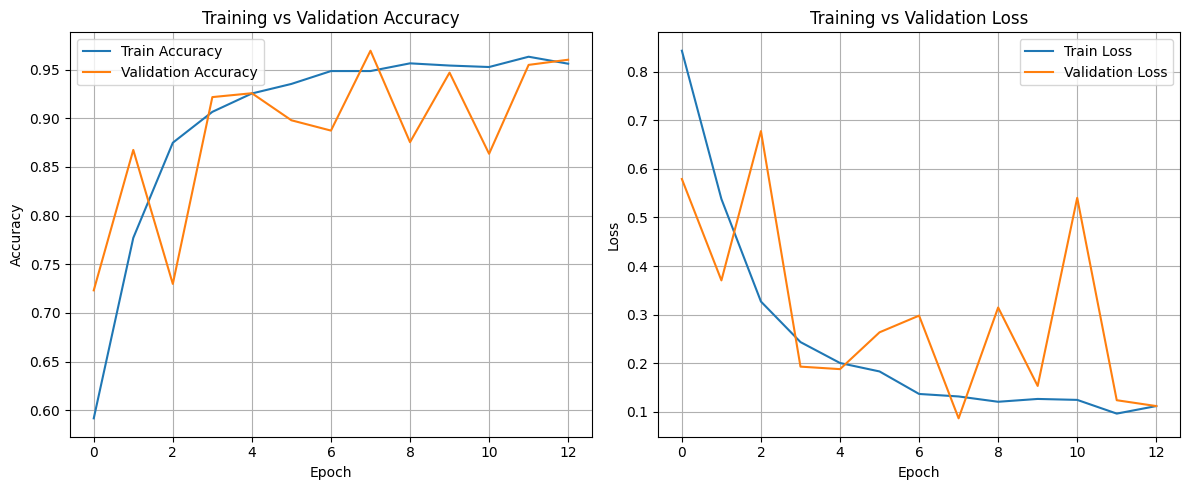

In [28]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluasi dan Visualisasi

In [33]:
# Evaluasi model di test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"🎯 Test Accuracy: {test_acc:.2%}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 723ms/step - accuracy: 0.9665 - loss: 0.0948
🎯 Test Accuracy: 96.60%


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 678ms/step


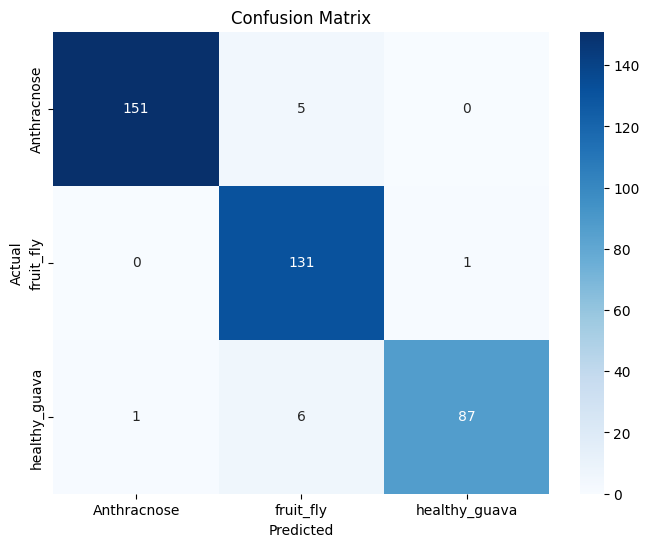

📋 Classification Report:
               precision    recall  f1-score   support

  Anthracnose       0.99      0.97      0.98       156
    fruit_fly       0.92      0.99      0.96       132
healthy_guava       0.99      0.93      0.96        94

     accuracy                           0.97       382
    macro avg       0.97      0.96      0.96       382
 weighted avg       0.97      0.97      0.97       382



In [35]:
import seaborn as sns
# Prediksi label
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Label asli
y_true = test_generator.classes

# Nama kelas
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("📋 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

In [29]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(model, img_path, class_labels, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)

    # Tampilkan gambar dan hasil
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")
    plt.show()

Saving 10_unsharp_clahe_augmented_5.png to 10_unsharp_clahe_augmented_5.png
📷 Prediksi untuk: 10_unsharp_clahe_augmented_5.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


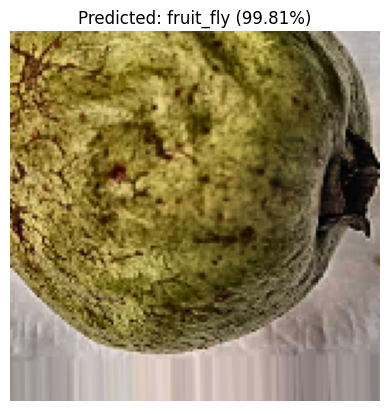

In [32]:
from google.colab import files
class_labels = list(train_generator.class_indices.keys())
uploaded = files.upload()

for fn in uploaded.keys():
    print(f"📷 Prediksi untuk: {fn}")
    predict_image(model, fn, class_labels)

## Konversi Model

## saveModel

In [47]:
model.export("my_model_savedmodel")

Saved artifact at 'my_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133928108665808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108667536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108667344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108668304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108668112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108669072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108666960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108670608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108670416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108670800: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [50]:
model.save("my_model.keras")

In [51]:
model.save("my_model.h5")

## Tensorflow Lite

In [48]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpt5j9zzu2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133928108665808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108667536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108667344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108668304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108668112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108669072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108666960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108670608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108670416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133928108670800: TensorSpec(shape=(), dtype=tf.resource, name=None)


## Tensorflow JS

In [49]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    my_model_savedmodel \
    tfjs_model

2025-04-26 05:31:33.411185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745645493.450076   44883 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745645493.462154   44883 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-26 05:31:39.915568: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1745645500.113135   44883 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

In [52]:
from google.colab import files

# Download model TFLite
files.download("model.tflite")

# Download model Keras
files.download("my_model.keras")

# Download model H5
files.download("my_model.h5")

# Zip & download TFJS model
!zip -r tfjs_model.zip tfjs_model
files.download("tfjs_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard3of5.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of5.bin (deflated 7%)
  adding: tfjs_model/model.json (deflated 89%)
  adding: tfjs_model/group1-shard4of5.bin (deflated 7%)
  adding: tfjs_model/group1-shard5of5.bin (deflated 7%)
  adding: tfjs_model/group1-shard2of5.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)